In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import openslide as ops
from PIL import Image
from matplotlib import pyplot as plt
import random
import time
import cv2
from pprint import pprint
from tqdm.notebook import tqdm

C:\Users\scott\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# test_im = ops.OpenSlide('/data/MIP_G3/wsibulk/images/103S.tif')
# print(test_im.level_dimensions)
# print(test_im.level_downsamples)

# mask_path = "/data/wsibulk/annotations-tumor-bulk/masks/"
# img_path = "/data/wsibulk/images/"
# image_name = "103S.tif"

OpenSlideUnsupportedFormatError: Unsupported or missing image file

In [2]:
def extract_image_layer(mask_obj,level):
    """
    Outputs an array consisting of entire image at chosen layer
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask

    level: what res patch comes from
    """
    
    imagex, imagey = mask_obj.level_dimensions[level]
    print(imagex, ' ', imagey)

    image_rgba = np.array(mask_obj.read_region((0,0),level,(imagex,imagey)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)

    return image_rgb

def get_valid_coord_list(image,n):
    """
    Outputs a list of coordinates that fall on the edge of the mask that should be useful center coord for training and testing
    
    Inputes:
        image: openslide image object
        n: how many sample coordinates you want
    """
    lev = 3
    img = extract_image_layer(image,lev)*255;

    img_canny = cv2.Canny(mask_test,20,40)

    imx,imy = image.level_dimensions[lev]
    coord_list = []
    for i in range(imy):
        for j in range(imx):
            if mask_canny[i,j] == 255:
                coord_list.append((i,j))
    output_list = random.sample(coord_list,n)
    return output_list

def extract_hooknet_patch(image,origin,tile_size,target_level,context_level):
    """
    Outputs a patch from target level and context level
    
    inputs: 
    image: Openslide multilevel image
    origin: center of image wrt lowest layer (highest resolution)
    tile_size: how large
    """
    target_downsample_factor = int(image.level_downsamples[target_level])
    context_downsample_factor = int(image.level_downsamples[context_level])
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = tile_size
    
    # print(imagex, ' ', imagey)
    # print(target_downsample_factor, ' ', context_downsample_factor)
    buffer_x = np.floor(tilex/2)
    buffer_y = np.floor(tiley/2)

    x_coord, y_coord = origin
    
    print(x_coord,y_coord)

    # top left coord for target and context images
    x_target = int(x_coord - buffer_x*target_downsample_factor)
    x_context = int(x_coord - buffer_x*context_downsample_factor)

    y_target = int(y_coord - buffer_y*target_downsample_factor)
    y_context = int(y_coord - buffer_y*context_downsample_factor)

    target_rgba = np.array(image.read_region((x_target,y_target),target_level,(tilex,tiley)))
    target_rgb = cv2.cvtColor(target_rgba, cv2.COLOR_RGBA2RGB)

    context_rgba = np.array(image.read_region((x_context,y_context),context_level,(tilex,tiley)))
    context_rgb = cv2.cvtColor(context_rgba, cv2.COLOR_RGBA2RGB)
    return target_rgb, context_rgb


def extract_double_patch(image,mask,origin,size,level=1):
    """
    Simultaneously extracts a patch from an image and its corresponding mask at the given coordinates and size
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask
    origin: center of image (x,y) wrt layer 0
    size: size of patch (x,y)
    level: what res patch comes from
    """
    
    downsample_factor = int(image.level_downsamples[level])
    
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = size
    # print(tilex, ' ', tiley)
    #Center of patch at layer 0
    x_coord, y_coord = origin
    # print(x_coord, ' ', y_coord)

    # top left coord for images
    x_target = int(x_coord - tilex/2*downsample_factor)
    y_target = int(y_coord - tiley/2*downsample_factor)
    print(x_target, ' ', y_target)

    image_rgba = np.array(image.read_region((x_target,y_target),level,(tilex,tiley)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)
    
    mask_rgba = np.array(mask.read_region((x_target,y_target),level,(tilex,tiley)))
    mask_rgb = cv2.cvtColor(mask_rgba, cv2.COLOR_RGBA2RGB)

    return image_rgb, mask_rgb
    

def extract_patch(image,origin,size,level=1):
    """
    Extracts a single patch from chosen image at chosen layer
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask
    origin: center of image (x,y) wrt layer 0
    size: size of patch (x,y)
    level: what res patch comes from
    """
    
    downsample_factor = int(image.level_downsamples[level])
    
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = size
    print(tilex, ' ', tiley)
    #Center of patch at layer 0
    x_coord, y_coord = origin
    print(x_coord, ' ', y_coord)

    # top left coord for images
    x_target = int(x_coord - tilex/2*downsample_factor)
    y_target = int(y_coord - tiley/2*downsample_factor)
    print(x_target, ' ', y_target)

    image_rgba = np.array(image.read_region((x_target,y_target),level,(tilex,tiley)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)


    return image_rgb


((63488, 40064), (31744, 20032), (15872, 10016), (7936, 5008), (3968, 2504), (1984, 1252), (992, 626), (496, 313))
((63488, 40064), (31744, 20032), (15872, 10016), (7936, 5008), (3968, 2504), (1984, 1252), (992, 626), (496, 313))
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
9000 22977


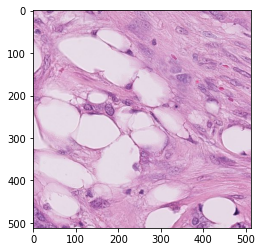

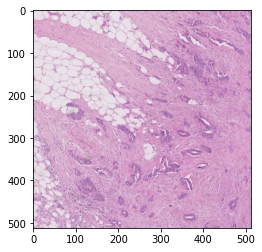

In [3]:
# Testing block - should display a single target/context image pair
mask_path = "C:/Users/scott/Downloads/103S_mask.tif"
img_path = "C:/Users/scott/Downloads/103S.tif"

image = ops.OpenSlide(img_path)
print(image.level_dimensions)
mask = ops.OpenSlide(mask_path)
print(mask.level_dimensions)
print(image.level_downsamples)
origin = (9000,22977)
size = (512,512)

image_test,mask_test = extract_hooknet_patch(image,origin,size,0,3)
plt.figure()
plt.imshow(image_test)
plt.figure()
plt.imshow(mask_test)

In [14]:
mask_path = "C:/Users/scott/Downloads/103S_mask.tif"
img_path = "C:/Users/scott/Downloads/103S.tif"

mask = ops.OpenSlide(mask_path)

mask_test = extract_image_layer(mask,5)*255;
plt.imshow(mask_test)

mask_canny = cv2.Canny(mask_test,20,40)
print(len(mask_test[mask_test==0]))
plt.figure()
plt.imshow(mask_canny)

print(np.shape(mask_canny))
# test = mask_canny
# test[test==255] = 0
# plt.figure()
# plt.imshow(test)

imx,imy = image.level_dimensions[layer]
coord_list = []
for i in range(imy):
    for j in range(imx):
        if mask_canny[i,j] == 255:
            coord_list.append([(i,j)])
len(coord_list)

1984   1252


OpenSlideError: TIFFRGBAImageGet failed

In [57]:
# Example Inference Dataset Creation - iterating over grid of points

# Load in image (should be looped for implimentation)
mask_path = "D:/School/Spring2022/mip/Tiling/123S_mask.tif"
img_path = "D:/School/Spring2022/mip/Tiling/123S.tif"

# Create OpenSlide Objects
image = ops.OpenSlide(img_path)
mask = ops.OpenSlide(mask_path)

# Patch Size
size = (1024,1024)

# Hooknet context layer
context_layer = 3

# % overlap in the x and y direction
overlap = (0.25,0.25)

grid_spacing = (round(size[0]*(1-overlap[0])),round(size[1]*(1-overlap[1])))

# Finding mask extents
mask_im = extract_image_layer(mask,7)
masky, maskx = mask.level_dimensions[7]
mask_df = mask.level_downsamples[7]
for x1 in range(maskx):
    layer = mask_im[x1,:]
    if 1 in layer:
        break
for y1 in range(masky):
    layer = mask_im[:,y1]
    if 1 in layer:
        break
for x2 in range(maskx-1, 0, -1):
    layer = mask_im[x2,:]
    if 1 in layer:
        break
for y2 in range(masky-1, 0, -1):
    layer = mask_im[:,y2]
    if 1 in layer:
        break
# Converting to layer 0 coordinates
x1 = round((x1+0.5)*mask_df)
x2 = round((x2+0.5)*mask_df)
y1 = round((y1+0.5)*mask_df)
y2 = round((y2+0.5)*mask_df)

x_coord_list = list(range(x1,x2,grid_spacing[0]))
if x2 not in x_coord_list:
    x_coord_list.append(x2) 
y_coord_list = list(range(y1,y2,grid_spacing[1]))
if y2 not in y_coord_list:
    y_coord_list.append(y2)

    
target_images = []
context_images = []
counter = 0

for j in y_coord_list:
    for i in x_coord_list:
        origin = (i,j)
        target,context = extract_hooknet_patch(image,origin,size,0,context_layer)
        target_images.append(target)
        context_images.append(context)
    break

496   313
8512 5184
9280 5184
10048 5184
10816 5184
11584 5184
12352 5184
13120 5184
13888 5184
14656 5184
15424 5184
16192 5184
16960 5184
17728 5184
18496 5184
19264 5184
20032 5184
20800 5184
21568 5184
22336 5184
23104 5184


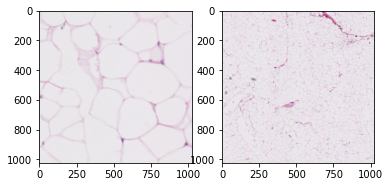

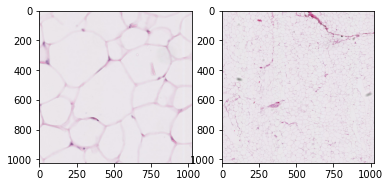

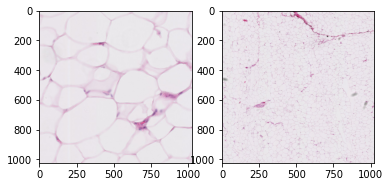

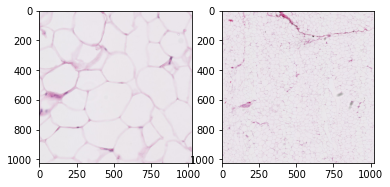

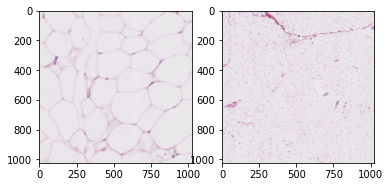

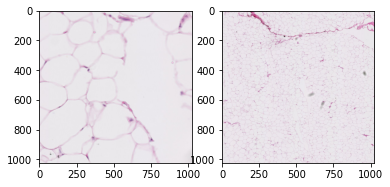

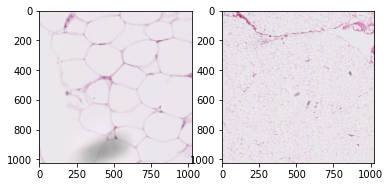

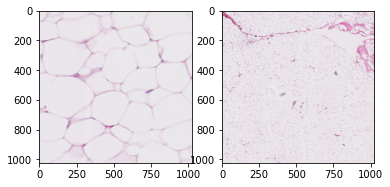

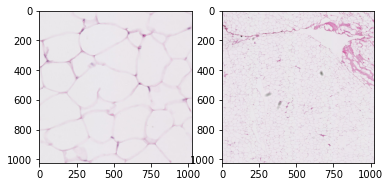

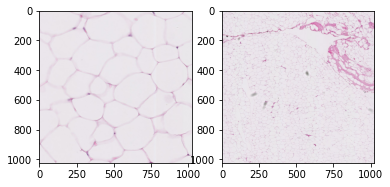

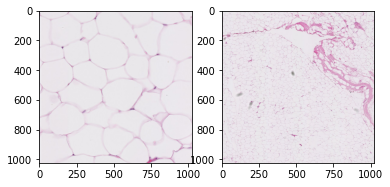

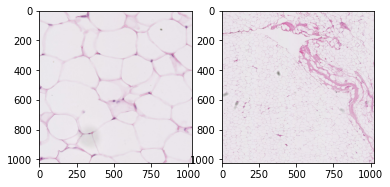

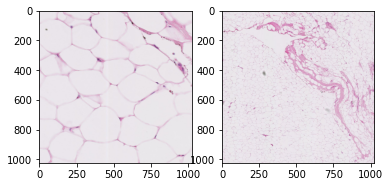

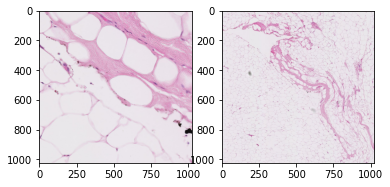

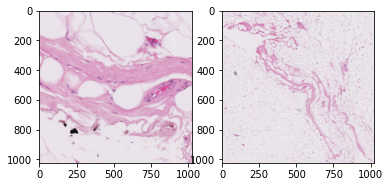

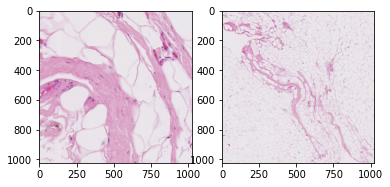

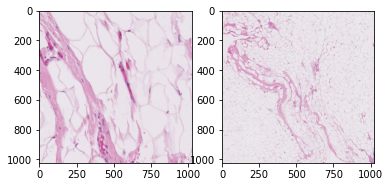

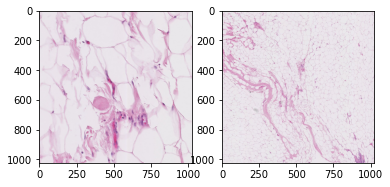

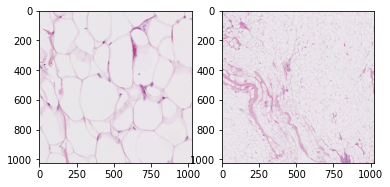

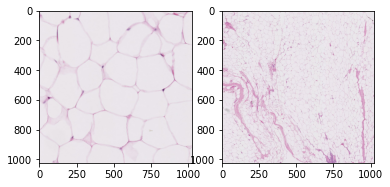

In [58]:
for ii in range(20):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(target_images[ii])
    plt.subplot(1,2,2)
    plt.imshow(context_images[ii])
